In [237]:
import pandas as pd
import pandas_ta as ta

In [242]:
df = pd.read_csv("../data/1d/VRSK.csv")
df.set_index("Date", inplace=True)
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2013-05-23 00:00:00-04:00,58.753020,59.402116,58.084254,58.998890,1053200,0.0,0.0
2013-05-24 00:00:00-04:00,58.969390,58.998897,57.985911,58.359634,1400800,0.0,0.0
2013-05-28 00:00:00-04:00,58.025251,58.644844,58.025251,58.516991,1468800,0.0,0.0
2013-05-29 00:00:00-04:00,58.330119,58.575989,57.700689,58.320282,1371000,0.0,0.0
2013-05-30 00:00:00-04:00,58.241607,58.674336,58.113753,58.202267,1440100,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-17 00:00:00-04:00,219.660004,220.490005,217.979996,219.119995,1087000,0.0,0.0
2023-05-18 00:00:00-04:00,217.300003,221.000000,217.300003,220.630005,790900,0.0,0.0
2023-05-19 00:00:00-04:00,221.000000,222.929993,220.630005,222.119995,1137900,0.0,0.0


In [243]:
import numpy as np

# Squeeze Momentum Indicator

LENGTH_BB = 20 # BB Length
MULT_BB = 2 # BB Multiplier
LENGTH_KC = 20 # KC Length
MULT_KC = 1.5 # KC Multiplier

USE_TRUE_RANGE = True # Use True Range for KC

# Calculate BB
source = df["Close"]
basis = ta.sma(source, length=LENGTH_BB)
dev = MULT_KC * ta.stdev(source, length=LENGTH_BB)

upperBB = basis + dev
lowerBB = basis - dev

# Calculate KC
ma = ta.sma(source, length=LENGTH_KC)
range_val = ta.true_range(df["High"], df["Low"], df["Close"]) if USE_TRUE_RANGE else df["High"] - df["Low"]
rangema = ta.sma(range_val, length=LENGTH_KC)
upperKC = ma + rangema * MULT_KC
lowerKC = ma - rangema * MULT_KC

# Calculate Squeeze
sqzOn = (lowerBB > lowerKC) & (upperBB < upperKC)
sqzOff = (lowerBB < lowerKC) & (upperBB > upperKC)
noSqz = ~sqzOn & ~sqzOff

# Calculate Momentum
avg_high_low = (df["High"].rolling(LENGTH_KC).max() + df["Low"].rolling(LENGTH_KC).min())/2
sma_close = ta.sma(df["Close"], LENGTH_KC)
val = ta.linreg(source - (avg_high_low + sma_close)/2, LENGTH_KC, 0)

# replace all NaN values with 0
val = val.replace(np.nan, 0)

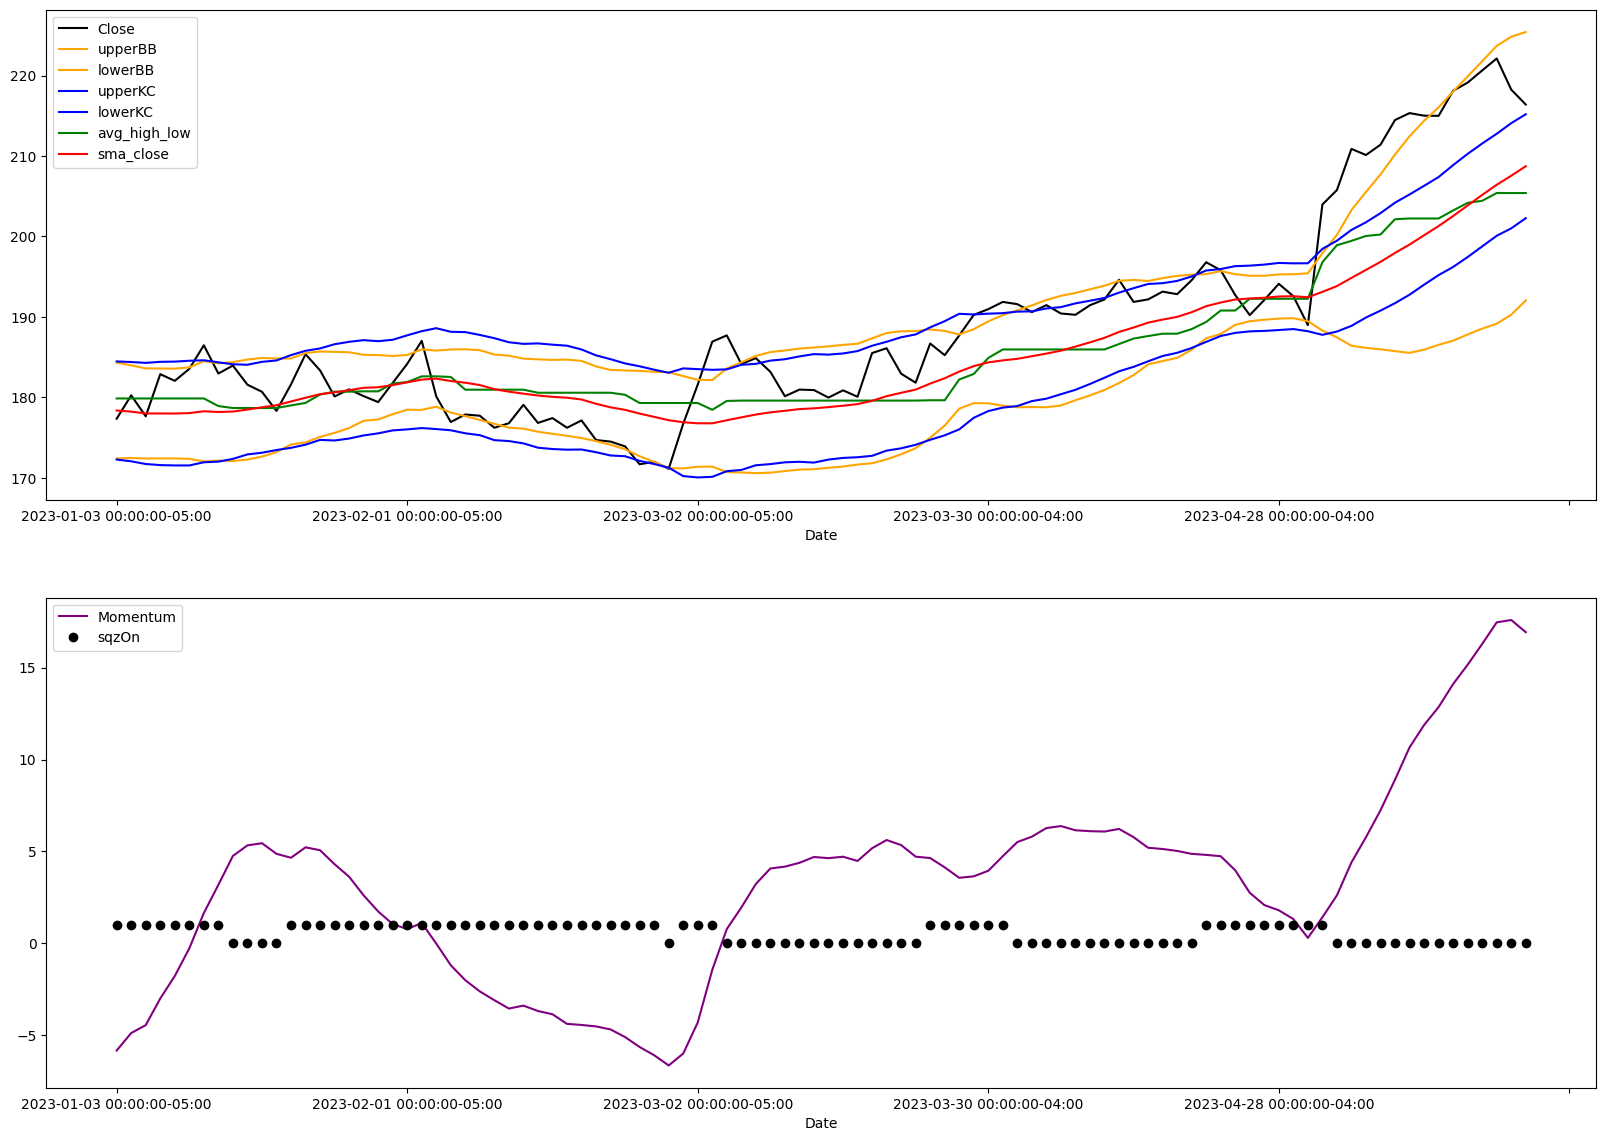

In [244]:
cutoff = "2023-01-01"
df = df[df.index > cutoff]
upperBB = upperBB[upperBB.index > cutoff]
lowerBB = lowerBB[lowerBB.index > cutoff]
upperKC = upperKC[upperKC.index > cutoff]
lowerKC = lowerKC[lowerKC.index > cutoff]
avg_high_low = avg_high_low[avg_high_low.index > cutoff]
sma_close = sma_close[sma_close.index > cutoff]
sqzOn = sqzOn[sqzOn.index > cutoff]
sqzOff = sqzOff[sqzOff.index > cutoff]
val = val[val.index > cutoff]

import matplotlib.pyplot as plt
# set figsize big height
plt.subplot(2, 1, 1)

# plot the data
df["Close"].plot(figsize=(20,80), color="black")
upperBB.plot(figsize=(20,8), color="orange")
lowerBB.plot(figsize=(20,8), color="orange")
upperKC.plot(figsize=(20,8), color="blue")
lowerKC.plot(figsize=(20,8), color="blue")

avg_high_low.plot(figsize=(20,8), color="green")
sma_close.plot(figsize=(20,8), color="red")

plt.legend(["Close", "upperBB", "lowerBB", "upperKC", "lowerKC", "avg_high_low", "sma_close"])

plt.subplot(2, 1, 2)
val.plot(figsize=(20,80), color="purple")

# plot dots where sqzOn is true, and crosses where sqzOff is true
sqzOn.astype(int).plot(figsize=(20,14), color="black", marker="o", linestyle="None")

plt.legend(["Momentum", "sqzOn"])

In [241]:
# now we've added squeeze on and squeeze off, let's add support and resistance w breakout points

In [230]:
lefbars = 15
rightbars = 15
volume_threshold = 15


In [231]:
from collections import deque
import numpy as np


def clean_deque(i, k, deq, df, key, isHigh):
    if deq and deq[0] == i - k:
        deq.popleft()
    if isHigh:
        while deq and df.iloc[i][key] > df.iloc[deq[-1]][key]:
            deq.pop()
    else:
        while deq and df.iloc[i][key] < df.iloc[deq[-1]][key]:
            deq.pop()

def pivotPoints(pivot=None,data=None):
    """
    This function calculates the pivot points based on the pivot lenght.
    These can be HH, LH , HL, LL values based on the adjacent pivots 
    which occur based on the length of the pivot.
    """

    data['PH'] = False
    data['PHV'] = np.NaN
    data['PL'] = False
    data['PLV'] = np.NaN
    keyHigh = 'High'
    keyLow = 'Low'
    win_size = pivot * 2 + 1
    deqHigh = deque()
    deqLow = deque()
    max_idx = 0
    min_idx = 0
    i = 0
    j = pivot
    pivot_low = None
    pivot_high = None
    for index, row in data.iterrows():
        if i < win_size:
            clean_deque(i, win_size, deqHigh, data, keyHigh, True)
            clean_deque(i, win_size, deqLow, data, keyLow, False)
            deqHigh.append(i)
            deqLow.append(i)
            if data.iloc[i][keyHigh] > data.iloc[max_idx][keyHigh]:
                max_idx = i
            if data.iloc[i][keyLow] < data.iloc[min_idx][keyLow]:
                min_idx = i
            if i == win_size-1:
                if data.iloc[max_idx][keyHigh] == data.iloc[j][keyHigh]:
                    data.at[data.index[j], 'PH'] = True
                    pivot_high = data.iloc[j][keyHigh]
                if data.iloc[min_idx][keyLow] == data.iloc[j][keyLow]:
                    data.at[data.index[j], 'PL'] = True
                    pivot_low = data.iloc[j][keyLow]
        if i >= win_size:
            j += 1
            clean_deque(i, win_size, deqHigh, data, keyHigh, True)
            clean_deque(i, win_size, deqLow, data, keyLow, False)
            deqHigh.append(i)
            deqLow.append(i)
            pivot_val = data.iloc[deqHigh[0]][keyHigh]
            if pivot_val == data.iloc[j][keyHigh]:
                data.at[data.index[j], 'PH'] = True
                pivot_high = data.iloc[j][keyHigh]
            if data.iloc[deqLow[0]][keyLow] == data.iloc[j][keyLow]:
                data.at[data.index[j], 'PL'] = True
                pivot_low = data.iloc[j][keyLow]

        data.at[data.index[j], 'PHV'] = pivot_high
        data.at[data.index[j], 'PLV'] = pivot_low
        i = i + 1

    return data

In [232]:
pivots = pivotPoints(pivot=1,data=df)
pivots

/var/folders/gs/c8fmpn2x69s6f023jym_dvdw0000gn/T/ipykernel_81425/2714517808.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PH'] = False
/var/folders/gs/c8fmpn2x69s6f023jym_dvdw0000gn/T/ipykernel_81425/2714517808.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PHV'] = np.NaN
/var/folders/gs/c8fmpn2x69s6f023jym_dvdw0000gn/T/ipykernel_81425/2714517808.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,PH,PHV,PL,PLV
Date,,,,,,,,,,,
2023-01-03 00:00:00-05:00,177.399994,179.350006,176.020004,177.339996,644400,0.0,0.0,False,NaN,False,NaN
2023-01-04 00:00:00-05:00,179.839996,181.639999,178.699997,180.250000,603200,0.0,0.0,True,181.639999,False,NaN
2023-01-05 00:00:00-05:00,178.830002,179.059998,176.360001,177.639999,693300,0.0,0.0,False,181.639999,True,176.360001
2023-01-06 00:00:00-05:00,179.509995,183.520004,178.000000,182.880005,728700,0.0,0.0,False,181.639999,False,176.360001
2023-01-09 00:00:00-05:00,183.000000,185.160004,181.880005,182.050003,1095800,0.0,0.0,True,185.160004,False,176.360001
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-17 00:00:00-04:00,219.660004,220.490005,217.979996,219.119995,1087000,0.0,0.0,False,216.600006,False,212.899994
2023-05-18 00:00:00-04:00,217.300003,221.000000,217.300003,220.630005,790900,0.0,0.0,False,216.600006,True,217.300003
2023-05-19 00:00:00-04:00,221.000000,222.929993,220.630005,222.119995,1137900,0.0,0.0,True,222.929993,False,217.300003


<Axes: xlabel='Date'>

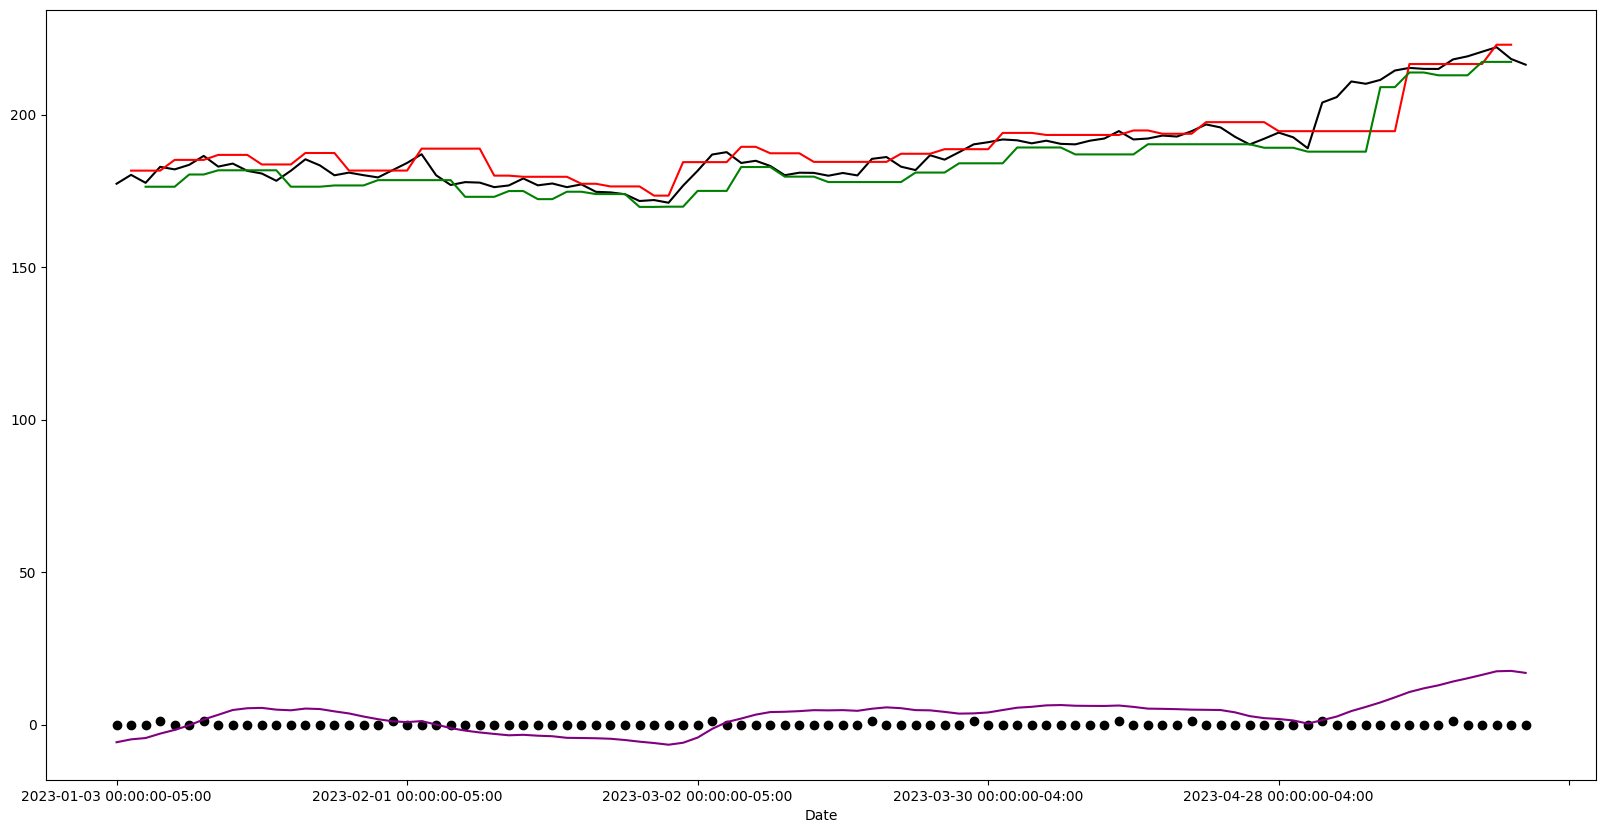

In [234]:
# graph pivots on top of price
df["Close"].plot(figsize=(20,8), color="black")

pivots["PHV"].plot(figsize=(20,8), color="red")
pivots["PLV"].plot(figsize=(20,8), color="green")
short = ta.ema(df["Volume"], 5)
long = ta.ema(df["Volume"], 10)
osc = 100*(short - long) / long


bull_cond = df["Open"] - df["Low"] > df["Close"] - df["Open"]
bull_break = ta.cross(df["Close"], pivots["PHV"]) & ~bull_cond

bull_break.astype(int).plot(figsize=(20,8), color="black", marker="o", linestyle="None")

val.plot(figsize=(20,10), color="purple")

# plot dots where sqzOn is true, and crosses where sqzOff is true
# sqzOn.astype(int).plot(figsize=(20,14), color="pink", marker="o", linestyle="None", alpha=0.5)